In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics, tree
from imblearn.under_sampling import RandomUnderSampler
from shap import plots, Explanation
import fasttreeshap
import time
import shap
from tqdm import tqdm
from matplotlib import ticker
import pickle
import lightgbm as lgb
from utils import *
import graphviz

pd.set_option('display.max_columns', None)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# you should run making_hikari2022_csv.ipynb before running this cell, since the two csv given with the paper have two differences
# to see what are the data types and the features of the dataset, you can take a look on the utils file
ds = pd.concat([
    pd.read_csv('datasets/HIKARI-2021/ALLFLOWMETER_HIKARI2021.csv', dtype=dtype_dict, usecols=selected_features),
    pd.read_csv('datasets/HIKARI-2021/ALLFLOWMETER_HIKARI2022.csv', dtype=dtype_dict, usecols=selected_features)], 
    ignore_index=True)
ds.head()

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,fwd_header_size_min,fwd_header_size_max,bwd_header_size_tot,bwd_header_size_min,bwd_header_size_max,flow_FIN_flag_count,flow_SYN_flag_count,flow_RST_flag_count,fwd_PSH_flag_count,bwd_PSH_flag_count,flow_ACK_flag_count,fwd_URG_flag_count,bwd_URG_flag_count,flow_CWR_flag_count,flow_ECE_flag_count,fwd_pkts_payload.min,fwd_pkts_payload.max,fwd_pkts_payload.tot,fwd_pkts_payload.avg,fwd_pkts_payload.std,bwd_pkts_payload.min,bwd_pkts_payload.max,bwd_pkts_payload.tot,bwd_pkts_payload.avg,bwd_pkts_payload.std,flow_pkts_payload.min,flow_pkts_payload.max,flow_pkts_payload.tot,flow_pkts_payload.avg,flow_pkts_payload.std,fwd_iat.min,fwd_iat.max,fwd_iat.tot,fwd_iat.avg,fwd_iat.std,bwd_iat.min,bwd_iat.max,bwd_iat.tot,bwd_iat.avg,bwd_iat.std,flow_iat.min,flow_iat.max,flow_iat.tot,flow_iat.avg,flow_iat.std,payload_bytes_per_second,fwd_subflow_pkts,bwd_subflow_pkts,fwd_subflow_bytes,bwd_subflow_bytes,fwd_bulk_bytes,bwd_bulk_bytes,fwd_bulk_packets,bwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.min,active.max,active.tot,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,traffic_category,Label
0,2.207588,15,14,6,6,6.794746,6.341763,13.136509,0.933333,464,20,40,492,32,44,2,2,2,6,5,26,0,0,0,0,0,742,1826.0,121.733333,220.736581,0,1448,5025.0,358.928571,552.239840,0,1448,6851.0,236.241379,424.859275,18.119812,1.963762e+06,2.207603e+06,1.576859e+05,5.205052e+05,7.867813,2.032929e+06,2.177950e+06,1.675346e+05,5.606267e+05,7.867813,1.963762e+06,2.207603e+06,78842.963491,3.696378e+05,3103.387105,7.5,7.0,913.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.207603e+06,2.207603e+06,2.207603e+06,2.207603e+06,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,0,Bruteforce-XML,True
1,15.624266,15,14,6,6,0.960045,0.896042,1.856087,0.933333,488,20,44,468,32,44,2,2,2,6,5,26,0,0,0,0,0,745,1829.0,121.933333,221.339257,0,1448,5025.0,358.928571,552.239840,0,1448,6854.0,236.344828,424.987166,20.980835,1.534300e+07,1.562428e+07,1.116020e+06,4.094889e+06,20.980835,1.541144e+07,1.559517e+07,1.199628e+06,4.270148e+06,10.013580,1.534300e+07,1.562428e+07,558009.896960,2.897622e+06,438.676603,7.5,7.0,914.5,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.883792e+04,2.524381e+05,2.812760e+05,1.406380e+05,158109.181742,1.534300e+07,1.534300e+07,1.534300e+07,1.534300e+07,0.0,29200,65160,0,Bruteforce-XML,True
2,12.203357,14,13,6,5,1.147225,1.065281,2.212506,0.928571,432,20,40,448,32,44,2,2,2,6,5,24,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,386.538462,817.479013,0,2896,6853.0,253.814815,592.570284,36.001205,1.196814e+07,1.220338e+07,9.387216e+05,3.314032e+06,15.020370,1.203674e+07,1.217482e+07,1.014569e+06,3.471107e+06,15.020370,1.196814e+07,1.220338e+07,469360.810060,2.345336e+06,561.566789,7.0,6.5,914.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.891302e+04,2.063251e+05,2.352381e+05,1.176190e+05,125449.251656,1.196814e+07,1.196814e+07,1.196814e+07,1.196814e+07,0.0,29200,65160,0,Bruteforce-XML,True
3,9.992448,14,13,6,5,1.401058,1.300983,2.702041,0.928571,432,20,40,436,32,44,2,2,2,6,5,24,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,386.538462,817.479013,0,2896,6853.0,253.814815,592.570284,50.067902,9.759205e+06,9.992470e+06,7.686515e+05,2.701448e+06,20.980835,9.828447e+06,9.963348e+06,8.302790e+05,2.833716e+06,20.980835,9.759205e+06,9.992470e+06,384325.770231,1.912152e+06,685.817940,7.0,6.5,914.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.952909e+04,2.037361e+05,2.332652e+05,1.166326e+05,123182.931318,9.759205e+06,9.759205e+06,9.759205e+06,9.759205e+06,0.0,29200,65160,0,Bruteforce-XML,True
4,7.780611,14,14,6,5,1.799345,1.799345,3.598689,1.000000,432,20,40,480,32,44,2,2,2,6,5,25,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,358.928571,792.173394,0,2896,6853.0,244.750000,583.468215,16.927719,7.545305e+06,7.780620e+06,5.985092e+

In [3]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783531 entries, 0 to 783530
Data columns (total 81 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   flow_duration             783531 non-null  float64
 1   fwd_pkts_tot              783531 non-null  uint64 
 2   bwd_pkts_tot              783531 non-null  uint64 
 3   fwd_data_pkts_tot         783531 non-null  uint64 
 4   bwd_data_pkts_tot         783531 non-null  uint64 
 5   fwd_pkts_per_sec          783531 non-null  float64
 6   bwd_pkts_per_sec          783531 non-null  float64
 7   flow_pkts_per_sec         783531 non-null  float64
 8   down_up_ratio             783531 non-null  float32
 9   fwd_header_size_tot       783531 non-null  uint64 
 10  fwd_header_size_min       783531 non-null  uint8  
 11  fwd_header_size_max       783531 non-null  uint8  
 12  bwd_header_size_tot       783531 non-null  uint64 
 13  bwd_header_size_min       783531 non-null  u

In [4]:
ds.describe()

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,fwd_header_size_min,fwd_header_size_max,bwd_header_size_tot,bwd_header_size_min,bwd_header_size_max,flow_FIN_flag_count,flow_SYN_flag_count,flow_RST_flag_count,fwd_PSH_flag_count,bwd_PSH_flag_count,flow_ACK_flag_count,fwd_URG_flag_count,bwd_URG_flag_count,flow_CWR_flag_count,flow_ECE_flag_count,fwd_pkts_payload.min,fwd_pkts_payload.max,fwd_pkts_payload.tot,fwd_pkts_payload.avg,fwd_pkts_payload.std,bwd_pkts_payload.min,bwd_pkts_payload.max,bwd_pkts_payload.tot,bwd_pkts_payload.avg,bwd_pkts_payload.std,flow_pkts_payload.min,flow_pkts_payload.max,flow_pkts_payload.tot,flow_pkts_payload.avg,flow_pkts_payload.std,fwd_iat.min,fwd_iat.max,fwd_iat.tot,fwd_iat.avg,fwd_iat.std,bwd_iat.min,bwd_iat.max,bwd_iat.tot,bwd_iat.avg,bwd_iat.std,flow_iat.min,flow_iat.max,flow_iat.tot,flow_iat.avg,flow_iat.std,payload_bytes_per_second,fwd_subflow_pkts,bwd_subflow_pkts,fwd_subflow_bytes,bwd_subflow_bytes,fwd_bulk_bytes,bwd_bulk_bytes,fwd_bulk_packets,bwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.min,active.max,active.tot,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size
count,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,7.835310e+05,783531.000000,7.835310e+05,783531.000000,7.835310e+05,783531.000000,783531.000000,7.835310e+05,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,7.835310e+05,783531.000000,783531.000000,783531.000000,783531.000000,7.835310e+05,783531.000000,783531.000000,783531.000000,783531.000000,7.835310e+05,783531.000000,783531.000000,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,783531.000000,783531.000000,783531.000000,7.835310e+05,783531.000000,7.835310e+05,783531.000000,783531.000000,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,783531.000000,783531.000000,783531.000000
mean,7.930232,15.141476,15.202140,6.076205,11.985713,2.457452e+03,1960.277241,4.417729e+03,0.828711,5.221322e+02,23.148409,28.325925,4.665602e+02,18.626142,22.381593,0.778524,1.156447,0.418391,5.386756,8.314095,28.377589,0.001020,0.000008,0.001668,0.000037,17.793925,193.943558,1.685628e+03,45.600529,53.879600,22.216197,1167.560257,1.975559e+04,266.243447,343.753524,17.805741,1178.124581,2.144121e+04,159.531792,275.836606,7.863213e+05,4.496497e+06,7.770665e+06,1.097694e+06,9.087544e+05,2.396059e+04,3.669306e+06,5.969705e+06,3.493875e+05,9.122481e+05,7.861756e+05,4.575104e+06,7.941801e+06,9.855074e+05,6.942865e+05,7.737873e+04,10.765978,10.812873,1144.741004,1.200525e+04,23.553719,4.742144e+03,0.034943,1.864668,6.219484e+03,4.144654e+06,6.273139e+05,8.291515e+05,9.390527e+05,7.090896e+05,1.153479e+05,3.233009e+06,4.344537e+06,7.002749e+06,3.663116e+06,5.879498e+05,25885.029520,26880.533083,7417.383553
std,97.220072,390.717612,395.026085,62.401492,393.515497,2.913841e+04,5229.838478,3.047502e+04,0.492997,1.484319e+04,12.629693,15.981276,1.259048e+04,12.781371,16.568396,0.999198,1.029890,0.812277,62.129340,145.891623,785.296047,0.032707,0.002767,0.048602,0.006490,32.828224,300.906381,6.378143e+04,62.585370,91.086309,43.025812,2464.742493,3.385688e+05,509.497456,595.534119,32.883272,2464.226347,3.469619e+05,258.848209,477.557042,6.638000e+06,2.064076e+07,9.716466e+07,6.798270e+06,4.600532e+06,8.692441e+05,1.961555e+07,6.336533e+07,1.924652e+06,4.739904e+06,6.637222e+06,2.069169e+07,9.722218e+07,6.707441e+06,3.368079e+06,3.841924e+06,71.788091,75.387846,14402.013478,1.259423e+05,976.003926,

In [5]:
ds.columns

Index(['flow_duration', 'fwd_pkts_tot', 'bwd_pkts_tot', 'fwd_data_pkts_tot',
       'bwd_data_pkts_tot', 'fwd_pkts_per_sec', 'bwd_pkts_per_sec',
       'flow_pkts_per_sec', 'down_up_ratio', 'fwd_header_size_tot',
       'fwd_header_size_min', 'fwd_header_size_max', 'bwd_header_size_tot',
       'bwd_header_size_min', 'bwd_header_size_max', 'flow_FIN_flag_count',
       'flow_SYN_flag_count', 'flow_RST_flag_count', 'fwd_PSH_flag_count',
       'bwd_PSH_flag_count', 'flow_ACK_flag_count', 'fwd_URG_flag_count',
       'bwd_URG_flag_count', 'flow_CWR_flag_count', 'flow_ECE_flag_count',
       'fwd_pkts_payload.min', 'fwd_pkts_payload.max', 'fwd_pkts_payload.tot',
       'fwd_pkts_payload.avg', 'fwd_pkts_payload.std', 'bwd_pkts_payload.min',
       'bwd_pkts_payload.max', 'bwd_pkts_payload.tot', 'bwd_pkts_payload.avg',
       'bwd_pkts_payload.std', 'flow_pkts_payload.min',
       'flow_pkts_payload.max', 'flow_pkts_payload.tot',
       'flow_pkts_payload.avg', 'flow_pkts_payload.std', 'fwd

We can see from this graph that we don't have highly correlated features.

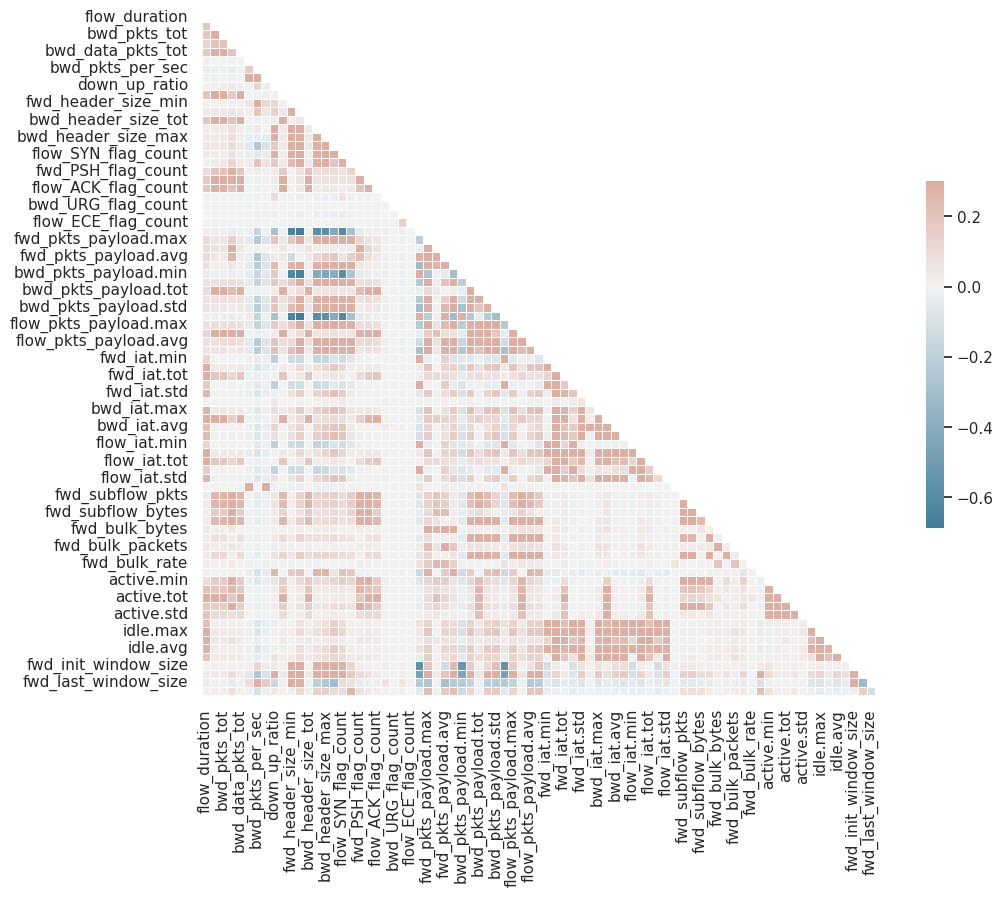

In [6]:
show_corr_matrix(ds)

In [7]:
compute_ratio(ds)

                     Ratio
traffic_category          
Benign               71.77
Background           21.72
Probing               2.98
XMRIGCC CryptoMiner   1.39
Bruteforce-XML        1.12
Bruteforce            1.02


In [8]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'num_leaves': 16, 
    'n_estimators': 48, 
    'max_depth': 6, 
    'n_jobs': -1, 
    'verbosity': 0
}

In [9]:
bst = lgb.LGBMClassifier(**params)
pv = DataPreprocessingAndValidation(ds, 7988, 5, lgb.LGBMClassifier, params)

In [10]:
X_res, y_res = pv.get_undersampled_ds()

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_res, ds.loc[y_res.index].Label, test_size = 0.2, random_state=12,  stratify=ds.loc[y_res.index].traffic_category)

In [12]:
%time pv.cross_validation(ds[x_features], ds.Label, y_res)

CPU times: user 42 s, sys: 209 ms, total: 42.2 s
Wall time: 28.2 s


(0.9331295319273147, 0.002569004146720268, 2.7099103927612305)

In [12]:
%time bst.fit(X_train, y_train)

CPU times: user 3.46 s, sys: 3.92 ms, total: 3.46 s
Wall time: 532 ms


LGBMClassifier(max_depth=6, n_estimators=48, n_jobs=-1, num_leaves=16,
               objective='binary', verbosity=0)

In [13]:
%time y_predicted_train = bst.predict(X_train)
%time y_predicted_test = bst.predict(X_test)

CPU times: user 334 ms, sys: 0 ns, total: 334 ms
Wall time: 71.2 ms
CPU times: user 116 ms, sys: 0 ns, total: 116 ms
Wall time: 18.1 ms


In [14]:
performanceMetricsDF(metrics, y_train, y_predicted_train, y_test, y_predicted_test)

,Measure,Train,Test
0,ACCURACY,0.928799,0.928879
1,PRECISION,0.876947,0.876925
2,RECALL,0.997574,0.997809
3,F1 SCORE,0.933380,0.933470
4,AUC,0.928801,0.928873


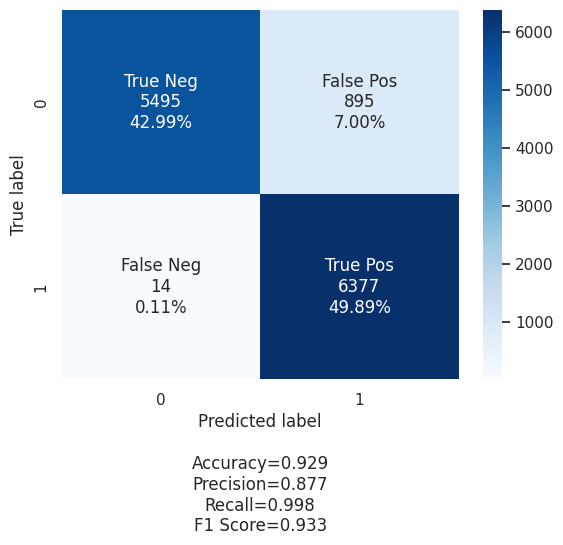

In [15]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories,
                      cmap='Blues')

In [16]:
# Create a plot for each tree in the model
for i in range(bst.n_estimators_):
    graph = lgb.create_tree_digraph(bst, tree_index=i, name='Tree {}'.format(i), show_info=['split_gain', 'internal_value', 'leaf_count'])
    graph.render(filename='tree_{}'.format(i), directory='lgb_data/tree', format='pdf')

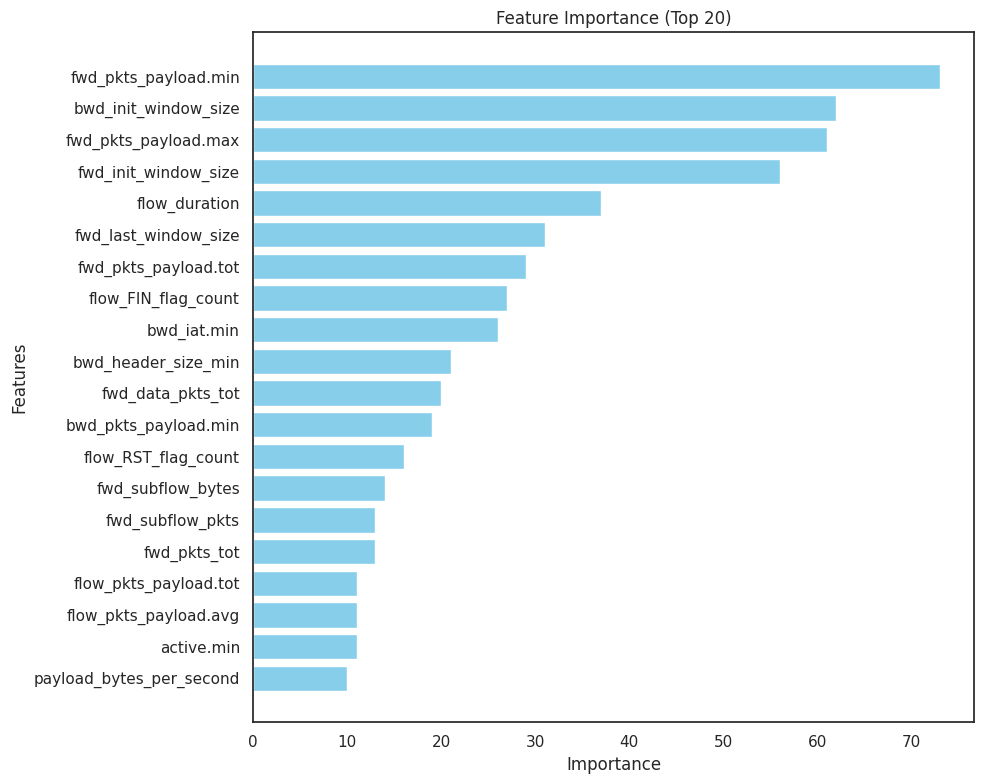

In [17]:
feature_importance = bst.feature_importances_
x_features_np = np.array(x_features)

# Sort indices based on feature importance
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_features = x_features_np[sorted_indices][:20][::-1]  # Select only the first 20 features
sorted_importance = feature_importance[sorted_indices][:20][::-1]  # Select importance values for the first 20 features

# Plotting
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
plt.barh(range(len(sorted_importance)), sorted_importance, color='skyblue')
plt.yticks(range(len(sorted_importance)), sorted_features)  # Use yticks for feature names
plt.ylabel('Features')
plt.xlabel('Importance')
plt.title('Feature Importance (Top 20)')
plt.tight_layout()

# Show plot
plt.show()

In [18]:
%%time

explainer = fasttreeshap.TreeExplainer(bst, X_train, algorithm='auto', n_jobs=-1, feature_perturbation="interventional")
sv = explainer.shap_values(X_train)

exp = Explanation(sv, 
                  np.mean(bst.predict(X_train)), 
                  data=X_train.values, 
                  feature_names=x_features)

 99%|===================| 50494/51123 [00:56<00:00]        

CPU times: user 56.6 s, sys: 201 ms, total: 56.8 s
Wall time: 56.6 s


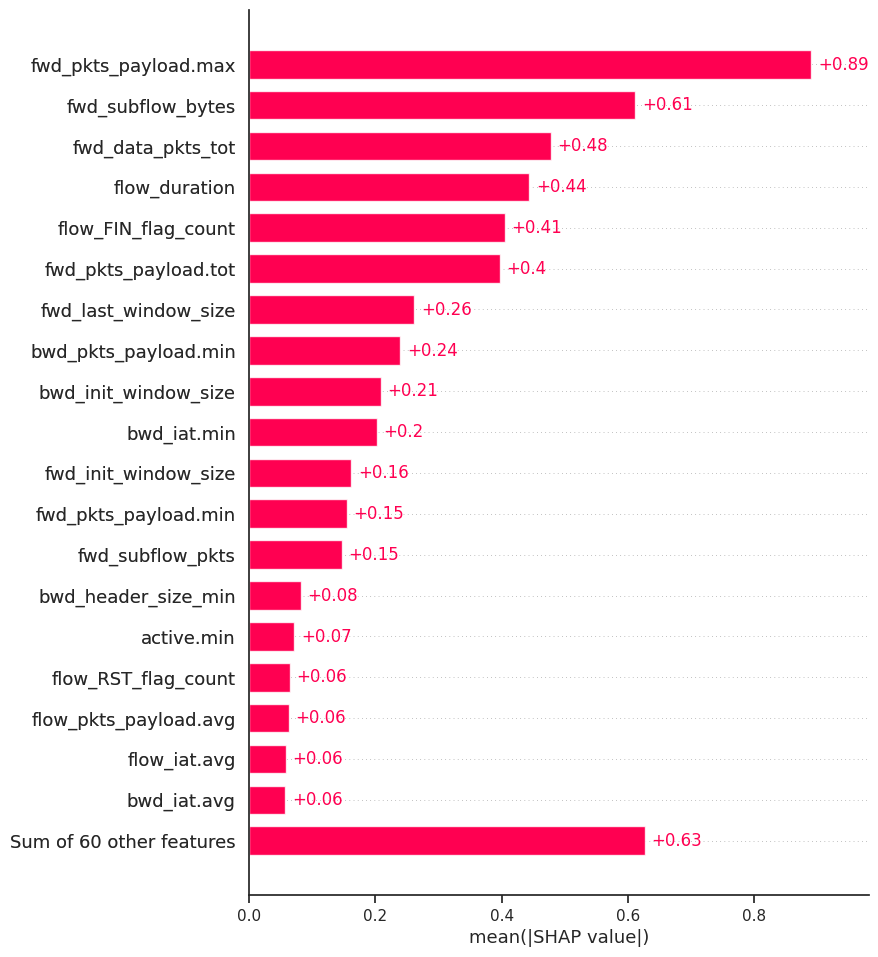

In [19]:
plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

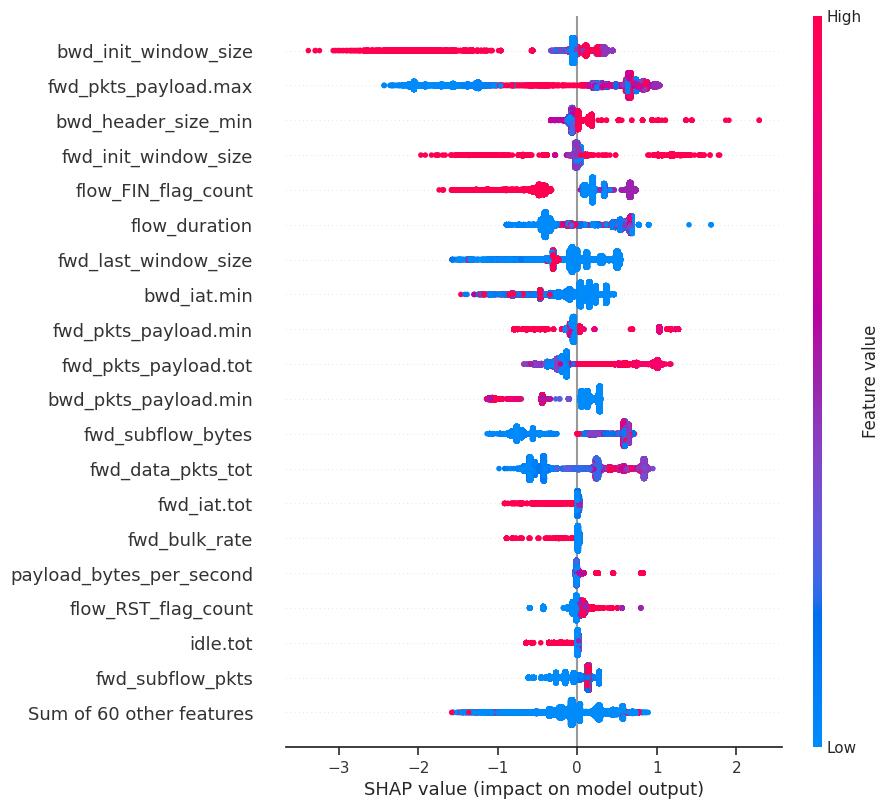

In [20]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

In [21]:
pv.feature_importance = pd.DataFrame(data={'importance' : exp.abs.mean(0).values, 'feature': x_features})
pv.feature_importance.sort_values('importance',ascending=False).head(20)

,importance,feature
26,0.889925,fwd_pkts_payload.max
58,0.611799,fwd_subflow_bytes
3,0.477658,fwd_data_pkts_tot
0,0.443603,flow_duration
15,0.405274,flow_FIN_flag_count
27,0.397459,fwd_pkts_payload.tot
78,0.261660,fwd_last_window_size
30,0.239678,bwd_pkts_payload.min
77,0.209117,bwd_init_window_size
45,0.202534,bwd_iat.min


In [22]:
pv.feature_above_zero = pv.feature_importance.query('importance > 0').sort_values('importance',ascending=False)['feature'].to_list()

In [23]:
%% time

if False:
    result = pv.recursive_reduction()
    feature_reduction_scores = pd.DataFrame({'F1_score': result[0], 'score_std': result[1], 'n_features': result[2], 'cv_time': result[3]})
    
    with open('lgb_data/feature_reduction_scores.pickle', 'wb') as handle:
        pickle.dump(feature_reduction_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('lgb_data/feature_reduction_scores.pickle', 'rb') as handle:
        feature_reduction_scores = pickle.load(handle)

UsageError: Cell magic `%%` not found.


In [24]:
%%time

result = pv.recursive_reduction()
feature_reduction_scores = pd.DataFrame({'F1_score': result[0], 'score_std': result[1], 'n_features': result[2], 'cv_time': result[3]})

testing with 61 features
testing with 60 features
testing with 59 features
testing with 58 features
testing with 57 features
testing with 56 features
testing with 55 features
testing with 54 features
testing with 53 features
testing with 52 features
testing with 51 features
testing with 50 features
testing with 49 features
testing with 48 features
testing with 47 features
testing with 46 features
testing with 45 features
testing with 44 features
testing with 43 features
testing with 42 features
testing with 41 features
testing with 40 features
testing with 39 features
testing with 38 features
testing with 37 features
testing with 36 features
testing with 35 features
testing with 34 features
testing with 33 features
testing with 32 features
testing with 31 features
testing with 30 features
testing with 29 features
testing with 28 features
testing with 27 features
testing with 26 features
testing with 25 features
testing with 24 features
testing with 23 features
testing with 22 features


<Axes: xlabel='n_features', ylabel='cv_time'>

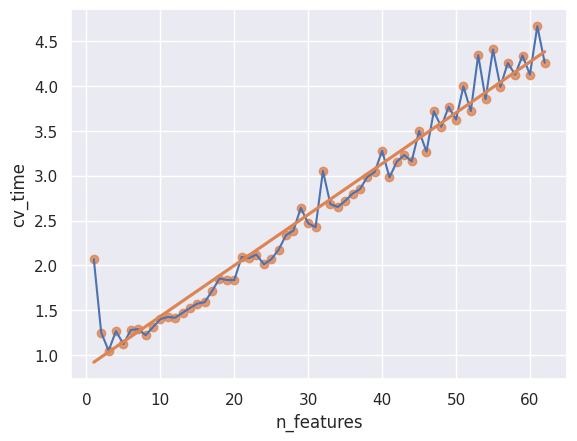

In [25]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="cv_time")
sns.regplot(data=feature_reduction_scores, x="n_features", y="cv_time", ci=None)  # ci=None removes confidence intervals

<Axes: xlabel='n_features', ylabel='F1_score'>

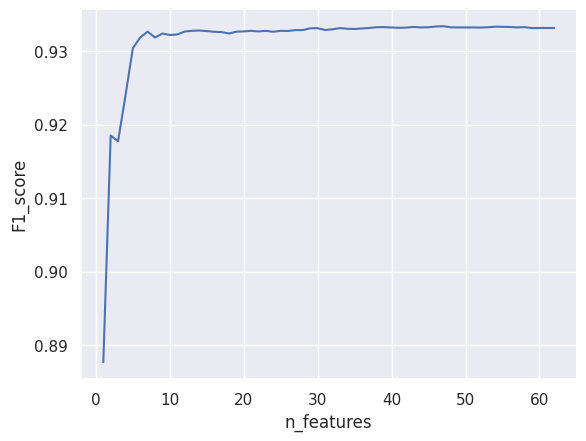

In [26]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="F1_score")

<Axes: xlabel='n_features', ylabel='score_std'>

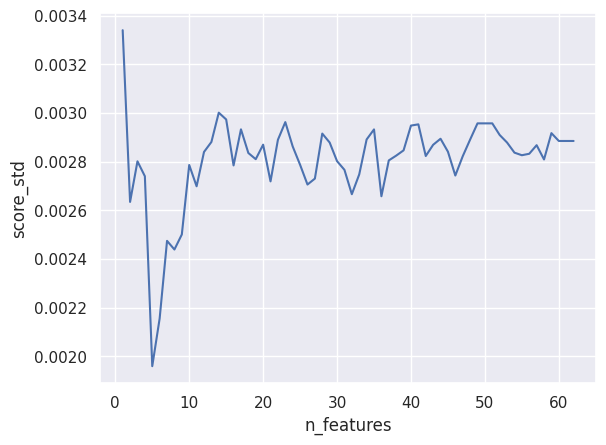

In [27]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="score_std")

In [28]:
feature_reduction_scores.sort_values('F1_score', ascending=False)

,F1_score,score_std,n_features,cv_time
15,0.933388,0.002823,47,3.719407
16,0.933341,0.002743,46,3.269457
8,0.933318,0.002837,54,3.856563
7,0.933302,0.002827,55,4.409731
19,0.933287,0.002870,43,3.231912
...,...,...,...,...
57,0.930403,0.001960,5,1.122489
58,0.923953,0.002741,4,1.267582
60,0.918521,0.002635,2,1.251759
59,0.917750,0.002802,3,1.049163


In [32]:
%%time

if False:
    zero_day_feature_reduction_scores = pv.run_zero_day_test()
    with open('lgb_data/zero_day_feature_reduction_scores.pickle', 'wb') as handle:
        pickle.dump(zero_day_feature_reduction_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('lgb_data/zero_day_feature_reduction_scores.pickle', 'rb') as handle:
        zero_day_feature_reduction_scores = pickle.load(handle)

FileNotFoundError: [Errno 2] No such file or directory: 'lgb_data/zero_day_feature_reduction_scores.pickle'

In [31]:
# here I create this detected variable, so that we can see how many attacks are detected because only by using the mean we didn't get the best one
zero_day_feature_reduction_scores['detected'] = np.where(zero_day_feature_reduction_scores['attack_recall'] > 0, 1, 0)

NameError: name 'zero_day_feature_reduction_scores' is not defined

In [ ]:
zero_day_feature_reduction_scores.query('attack_recall != 0').sort_values('attack_recall', ascending=False)

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,n_features,attack_name,fit_time,pred_time,detected
178,0.929382,0.999390,0.868540,0.929760,0.036230,2,Bruteforce-XML,0.016632,0.002137,1
175,0.669075,0.564806,0.820558,0.941670,0.030916,5,Bruteforce-XML,0.020134,0.001902,1
174,0.669196,0.564806,0.820922,0.941668,0.030795,6,Bruteforce-XML,0.020254,0.001609,1
177,0.666426,0.563891,0.814537,0.938806,0.030645,3,Bruteforce-XML,0.019073,0.001552,1
176,0.666426,0.563891,0.814537,0.938803,0.030816,4,Bruteforce-XML,0.019086,0.001548,1
127,0.469605,0.342787,0.745358,0.945297,0.028646,8,Bruteforce,0.022371,0.001599,1
128,0.469703,0.342787,0.745853,0.945426,0.028630,7,Bruteforce,0.021075,0.001528,1
134,0.215953,0.135407,0.533013,0.938331,0.029093,1,Bruteforce,0.012522,0.001325,1
131,0.139796,0.083562,0.427457,0.945853,0.028484,4,Bruteforce,0.017457,0.001548,1
132,0.139321,0.083257,0.426563,0.945647,0.028334,3,Bruteforce,0.016188,0.001475,1


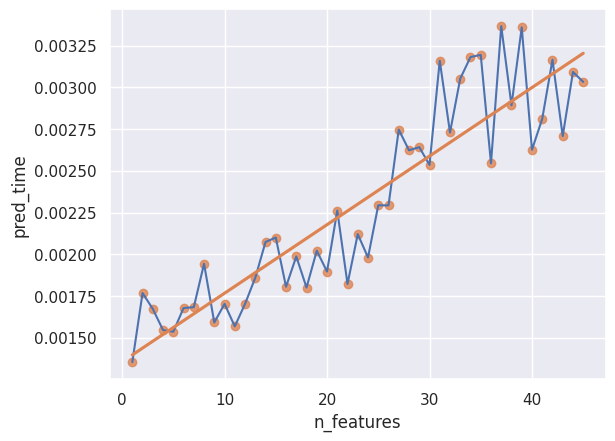

In [ ]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['pred_time','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='pred_time')
    sns.regplot(data=data, x="n_features", y="pred_time", ci=None)  # ci=None removes confidence intervals

print_plot()

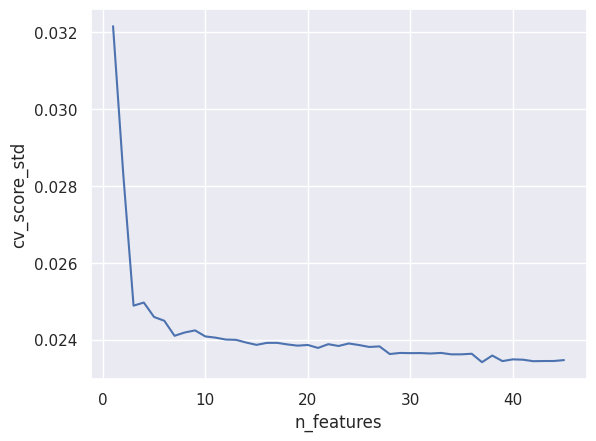

In [ ]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['cv_score_std','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='cv_score_std')

print_plot()

In [ ]:
zero_day_feature_reduction_scores.groupby('n_features')[['attack_f1','attack_recall','attack_precision','cv_score_avg','cv_score_std','fit_time','pred_time', 'detected']].mean().sort_values(['attack_recall', 'attack_precision'], ascending=False)

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,fit_time,pred_time,detected
n_features,,,,,,,,
2,0.238831,0.253355,0.263262,0.945032,0.028293,0.016693,0.001767,0.75
4,0.201556,0.161863,0.310499,0.951442,0.024968,0.019281,0.001545,0.50
3,0.201437,0.161787,0.310275,0.951401,0.024888,0.020561,0.001672,0.50
5,0.168638,0.141964,0.211824,0.953122,0.024593,0.018826,0.001535,0.50
6,0.168532,0.141888,0.211279,0.953198,0.024494,0.020723,0.001677,0.50
7,0.118107,0.086078,0.189652,0.953523,0.024103,0.023788,0.001683,0.50
8,0.117538,0.085773,0.186981,0.953432,0.024190,0.025761,0.001943,0.50
1,0.066513,0.040866,0.195511,0.927720,0.032159,0.013767,0.001353,0.75
11,0.006243,0.003507,0.028371,0.954101,0.024055,0.026430,0.001567,0.50


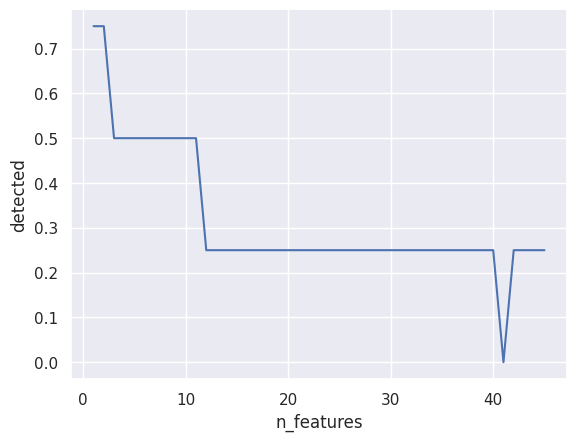

In [ ]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['detected','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='detected')

print_plot()

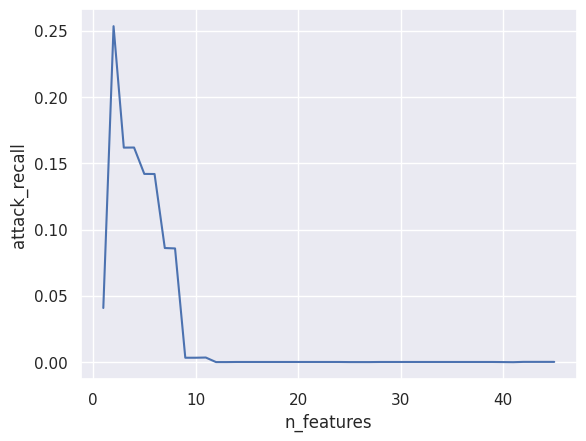

In [ ]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['attack_recall','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='attack_recall')

print_plot()

In [ ]:
zero_day_feature_reduction_scores.groupby('n_features')[['attack_f1','attack_recall','attack_precision','cv_score_avg','cv_score_std','fit_time','pred_time']].mean().sort_values('attack_f1', ascending=False)

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,fit_time,pred_time
n_features,,,,,,,
2,0.238831,0.253355,0.263262,0.945032,0.028293,0.016693,0.001767
4,0.201556,0.161863,0.310499,0.951442,0.024968,0.019281,0.001545
3,0.201437,0.161787,0.310275,0.951401,0.024888,0.020561,0.001672
5,0.168638,0.141964,0.211824,0.953122,0.024593,0.018826,0.001535
6,0.168532,0.141888,0.211279,0.953198,0.024494,0.020723,0.001677
7,0.118107,0.086078,0.189652,0.953523,0.024103,0.023788,0.001683
8,0.117538,0.085773,0.186981,0.953432,0.024190,0.025761,0.001943
1,0.066513,0.040866,0.195511,0.927720,0.032159,0.013767,0.001353
11,0.006243,0.003507,0.028371,0.954101,0.024055,0.026430,0.001567


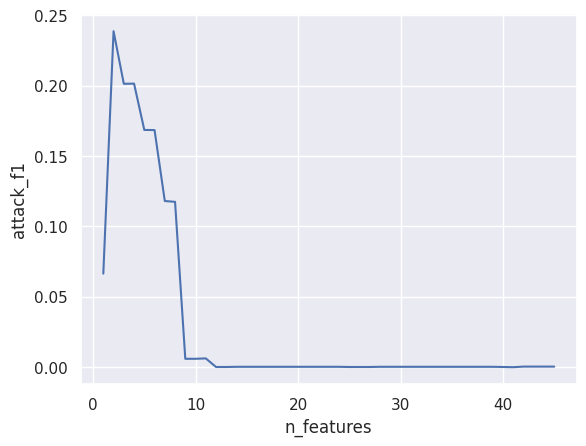

In [ ]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['attack_f1','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='attack_f1')

print_plot()

In [ ]:
zero_day_feature_reduction_scores.query('n_features == 2')

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,n_features,attack_name,fit_time,pred_time,detected
43,0.000000,0.000000,0.000000,0.935718,0.033061,2,XMRIGCC CryptoMiner,0.014872,0.001111,0
88,0.017192,0.009149,0.142180,0.969562,0.015789,2,Probing,0.019464,0.002341,1
133,0.008750,0.004880,0.042328,0.945089,0.028091,2,Bruteforce,0.015805,0.001480,1
178,0.929382,0.999390,0.868540,0.929760,0.036230,2,Bruteforce-XML,0.016632,0.002137,1
